## Part 1 implementing QAOA


### Question1 :
Write down in the cell below the Hamiltonian whose ground state is the solution to MaxCUT on an input graph $G=(V,E)$:


$$ H = \sum_{i,j\in E} \sigma_i \cdot \sigma_j $$

Justification : the solution of a 1/2-spin at each vertex of the graph is the ground state of an hamiltonian with pair-wise antiferromagnetic interaction at each edge (so J<0).


### Question 2:
Complete the implementation below of a simple, brute-force enumeration of all states computing the optimal solution to MaxCUT for the graph represented by 'edges'


In [ ]:
import numpy as np

graph1 = [(0,1),(0,2),(1,3),(2,3)]
graph2 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(5,8),(3,4),(4,5),(6,7),(7,8)]
graph3 = [(0,1),(1,2),(0,3),(1,4),(2,5),(3,6),(4,7),(3,4),(4,5),(6,7)]
graph4 = [(0,1),(1,2),(2,3),(4,5),(5,6),(6,7),(0,4),(1,5),(2,6),(3,7)]
graph5 = [(0,1),(0,2),(1,3),(2,4),(3,5),(4,5),(1,4)]
graph6 = [(0,1),(0,2),(1,3),(2,4),(1,4)]


# choice of graph
edges = graph6

nqubits = max([max(list(v)) for v in edges])+1 #le nombre de qbits est égal au nombre de edges

#nqubits = 5
graph7 = [(i,(i+1)%nqubits) for i in range(nqubits)]+[(1,4)] # % : renvoie le reste de la division du terme de gauche par le terme de droite

# COMPUTATION OF OPT.
best_value = len(edges)
best_b = 0
for x in range(2**nqubits):
    b = np.binary_repr(x, width=nqubits)    #conversion de x en représentation binaire, de longueur égale à nqbits
    #print(b)
    b = [int(b[i]) for i in range(nqubits)] #liste de longueur 5 des différents termes de b : liste des différentes valeurs possibles de chaque qbit représentant le graphe
    #print(b)
    # TODO: Complete the computation below:
    val = 0
    for edge in edges :
      i, j = edge 
      val = val + (1-2*b[i])*(1-2*b[j])
    # END TODO
    if val <= best_value:
        best_value = val
        best_b = b
print(best_value)
print(best_b)


-5
[1, 0, 0, 1, 1]


#### visualization of the graph

In [ ]:
!pip install myqlm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install wand
!apt install imagemagick
!python -m qat.magics.install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.14).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Traceback (most recent call last):
  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.8/dist-packages/qat/magics/install.py", line 25, in <module>
    install_qlm_magics()
  File "install.py", line 72, in qat.core.magic.install.install_qlm_magics
FileExistsError: Cannot install QLM magics bacause an IPython configuration is already defined. Plea

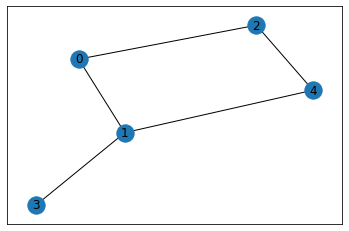

In [ ]:
import networkx as nx
G = nx.Graph()
for i,j in edges:
    G.add_edge(i,j)
nx.draw_networkx(G)

In [ ]:
from qat.lang.AQASM import Program, H, CNOT, RX, QRoutine, RZ, X, Z

In [ ]:
def U_ZZ(theta):
    
    zz_r = QRoutine()
    zz_r.apply(CNOT, 0, 1)
    zz_r.apply(RZ(theta), 1) # difference of convention between implemented version and what we need.
    zz_r.apply(CNOT, 0, 1)

    return zz_r

### Question 3

In [ ]:
from qat.lang.AQASM import RX, I, H
from math import*

In [ ]:
def one_qaoa_layer(n_qubits, edges, theta, beta):
    layer = QRoutine()
    #TODO: implement one qaoa layer
    for i in range(n_qubits) :
      layer.apply(RX(theta),i)
    for edge in edges:
        i, j = edge
        layer.apply(U_ZZ(beta), i, j)
    return layer

### Question 4

In [ ]:
from qat.qpus import get_default_qpu

def evaluate_parameters(n_qubits, edges, parameters, n_layers):
    
    prog = Program()
    qubits = prog.qalloc(n_qubits)
    
    # TODO: implement initialization+parameterized circuit
    for i in range(n_qubits):  #initialization : Hadmard gates
      prog.apply(H, qubits[i])
    for j in range(n_layers):
      prog.apply(one_qaoa_layer(n_qubits, edges, parameters[2*j], parameters[2*j+1]), qubits)
    # END TODO
    circ = prog.to_circ()
    
    job = circ.to_job()
    qpu = get_default_qpu()
    
    result = qpu.submit(job)
    
    # BEGIN TODO
    obs = 0
    for sample in result:
      # this loop is over all 2**nqubits states.
        # sample.state.bitstring contains the qubit values (nqubits 0 or 1)
        val = 0
        b = [int(i)*2+1 for i in sample.state.bitstring]
        for edge in edges :
          i, j = edge
          val = val + b[i]*b[j]
        obs = obs + val*sample.probability #moyenne pondérée des valeurs sur chaque échantillon 
    # END TODO
    return obs
    

In [ ]:
import numpy as np
np.random.random(3)

array([0.70508922, 0.6447501 , 0.1310967 ])

In [ ]:
from scipy.optimize import minimize

### Random initialisation

### Question 5: 
réponse à la question:

17.785085198764 17.61531499250702 17.61439738909888 17.614389311649877 17.614389296260626 17.466276494538302 17.17547861254753 17.017092191213116 16.9591232644097 16.92328495149661 16.86480495556949 16.790560264875023 16.77509606020844 16.774066962705987 16.773948752848636 16.77393074005688 16.773930358787737 16.77393035277093 18.06078557804523 17.82043193396318 17.353777592863768 17.050738955555385 16.88795897691424 16.61440366729383 16.40311943483838 16.362957483126753 16.35640898540833 16.35526698087833 16.35342031950082 16.35159242240127 16.35112987322315 16.350969020592174 16.350963726010264 16.350956827535153 16.350943981186607 16.350919836422214 16.350875611642675 16.350803558786602 16.350738126735624 16.350655780118657 16.350513582519458 16.350320157380395 16.350228988476523 16.350209005340915 16.350180251553077 16.350168702537264 16.350168086710006 16.35016802973699 16.3501680287844 16.350168028758734 19.722187651095766 19.446189240470733 18.416868780765046 17.750150725906874 

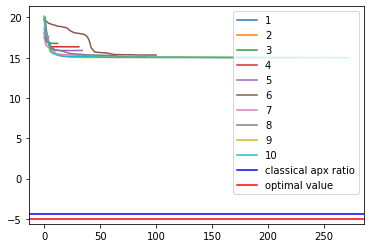

In [ ]:
import matplotlib.pylab as plt


for nlayers in range(1,11,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), np.random.random(num_params), callback=print_avg,)
    plt.plot(back_trace,label=str(nlayers))
# there exists a classical polynomial algorithm returning solutions within a factor of 0.878 of the optimal
# we must at least beat that. https://fr.wikipedia.org/wiki/Coupe_maximum
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()


On peut voir sur le graphique ci-dessus qu'il y a une erreur dans mon code...

### Question 6: smart initialization

In [1]:
T = 1.

for nlayers in range(3,6,1):
    num_params = 2*nlayers

    back_trace = []
    def print_avg(xk):
        eva = evaluate_parameters(nqubits, edges, xk,nlayers)
        back_trace.append(eva)
        print(eva, end=' ')

    # TODO implement parameter init
    parameters_init = []
    delta_t = T/nlayers 
    for k in range(nlayers):
      parameters_init.append((1-k/nlayers)*delta_t) #theta k
      parameters_init.append(delta_t*k/nlayers) #beta k
    # END TODO        
    opt_res = minimize(lambda x : evaluate_parameters(nqubits, edges, x, nlayers), 
                       parameters_init, 
                       callback=print_avg,)
plt.axhline(0.878*best_value, color='b', label="classical apx ratio")
plt.axhline(best_value,color='r',label='optimal value')
plt.legend()


NameError: ignored